In [8]:
# Common
import os
import keras
import numpy as np
from tqdm import tqdm
import cv2 as cv
from glob import glob
import tensorflow as tf

# Data 

# Data Viz
import matplotlib.pyplot as plt

# Model 
from keras import Sequential
from keras.layers import Conv2D, Conv2DTranspose, InputLayer, Layer, Input, Dropout, MaxPool2D, concatenate
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
path = r'D:/Projects/Trinetra Datasets/train/'
image_paths = sorted(glob(path + "*.jpg"))
SIZE = 256
images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 3))
masks = np.zeros(shape=(len(image_paths), SIZE, SIZE, 3))

for i in tqdm(range(len(image_paths))):
    path = image_paths[i]
    image = cv.imread(path)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    img = image[:,:256,:]/255.0
    img = tf.image.resize(img,(SIZE, SIZE))
    mask = image[:,256:,:]/255.0
    mask = tf.image.resize(mask,(SIZE, SIZE))
    images[i] = img
    masks[i] = mask

100%|██████████| 2500/2500 [00:51<00:00, 48.44it/s]


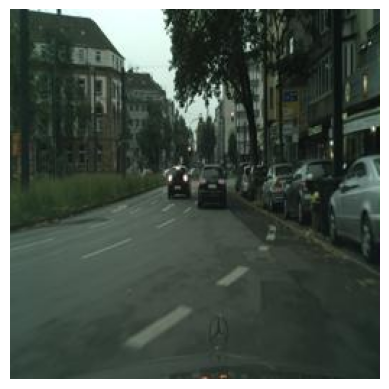

In [3]:
plt.imshow(images[45])
plt.axis('off')
plt.show()

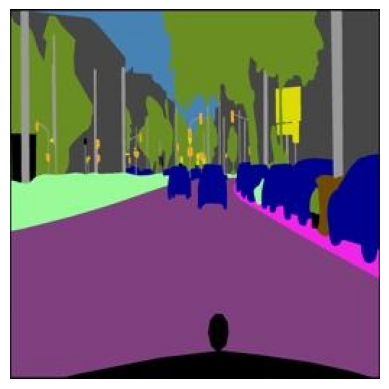

In [4]:
plt.imshow(masks[45])
plt.axis('off')
plt.show()

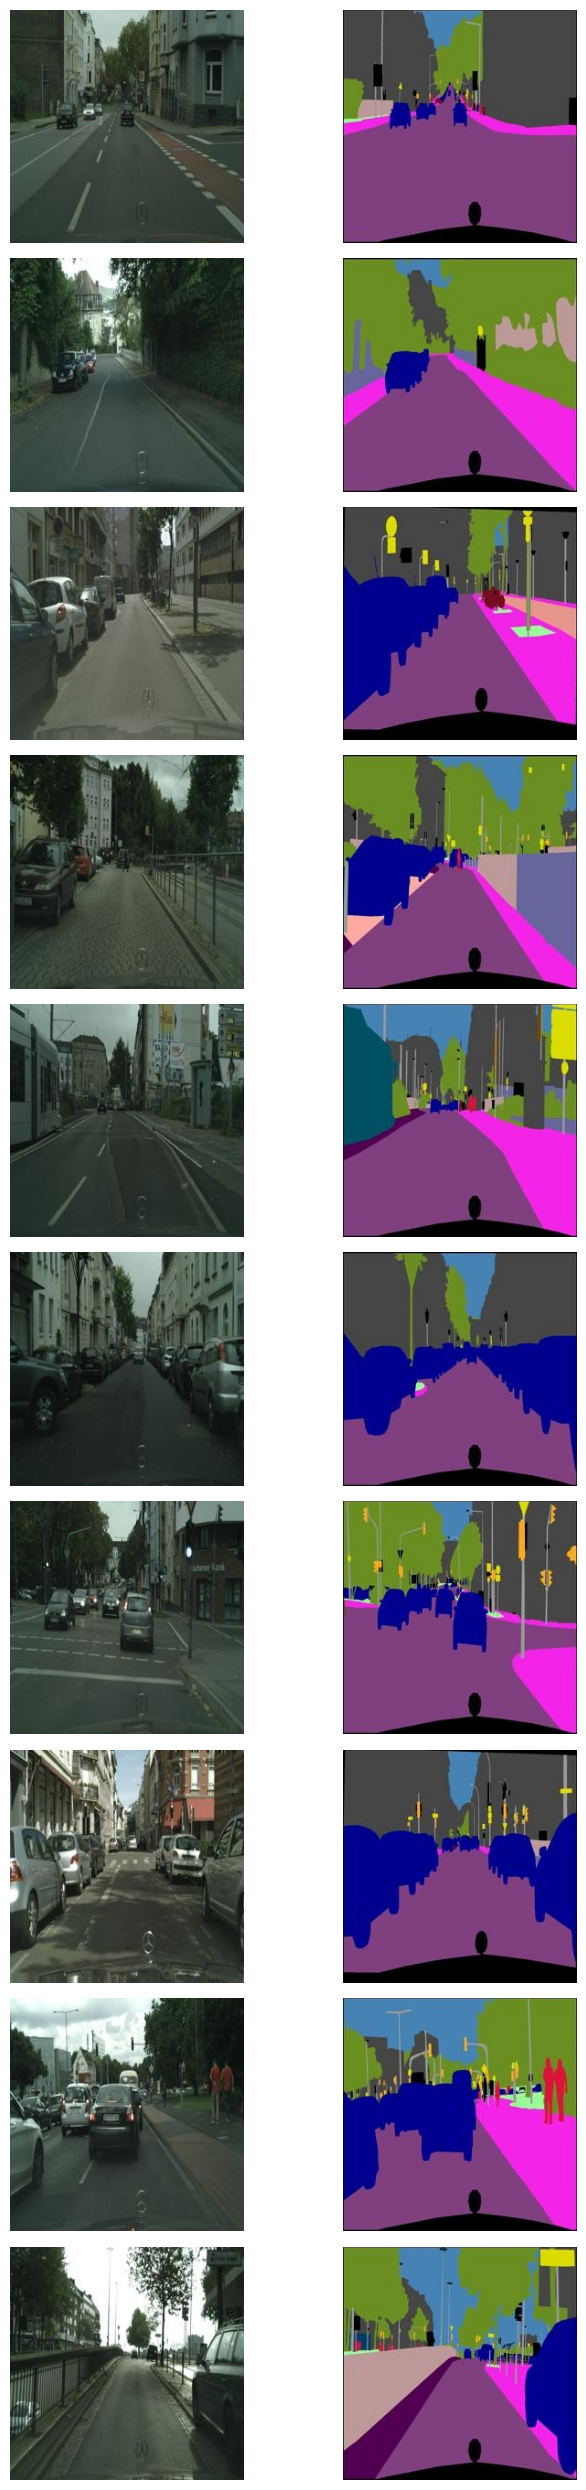

In [5]:
plt.figure(figsize=(8,25))
for i in range(1,21):
    plt.subplot(10,2,i)
    if i%2!=0:
        id = np.random.randint(len(images))
        image = images[id]
        plt.imshow(image)
        plt.axis('off')
    elif i%2==0:
        mask = masks[id]
        plt.imshow(mask)
        plt.axis('off')  
plt.tight_layout()
plt.show()

In [6]:
X_train, y_train = images[:2900], masks[:2900]
X_valid, y_valid = images[2900:], masks[2900:]

In [33]:
class EncoderLayerBlock(Layer):
    def __init__(self, filters, rate, pooling=True):
        super(EncoderLayerBlock, self).__init__()
        self.filters = filters
        self.rate = rate
        self.pooling = pooling

        self.c1 = Conv2D(self.filters, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')
        self.drop = Dropout(self.rate)
        self.c2 = Conv2D(self.filters, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')
        self.pool = MaxPool2D(pool_size=(2,2))

    def call(self, X):
        x = self.c1(X)
        x = self.drop(x)
        x = self.c2(x)
        if self.pooling:
            y = self.pool(x)
            return y, x
        else: 
            return x

    def get_config(self):
        base_estimator = super().get_config()
        return {
            **base_estimator,
            "filters":self.filters,
            "rate":self.rate,
            "pooling":self.pooling
        }

#  Decoder Layer
class DecoderLayerBlock(Layer):
    def __init__(self, filters, rate, padding='same'):
            super(DecoderLayerBlock, self).__init__()
            self.filters = filters
            self.rate = rate
            self.cT = Conv2DTranspose(self.filters, kernel_size=3, strides=2, padding=padding)
            self.next = EncoderLayerBlock(self.filters, self.rate, pooling=False)

    def call(self, X):
        X, skip_X = X
        x = self.cT(X)
        c1 = concatenate([x, skip_X])
        y = self.next(c1)
        return y 

    def get_config(self):
        base_estimator = super().get_config()
        return {
            **base_estimator,
            "filters":self.filters,
            "rate":self.rate,
        }

#  Callback 
class ShowProgress(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        id = np.random.randint(len(X_valid))
        rand_img = X_valid[id][np.newaxis,...]
        pred_mask = self.model.predict(rand_img)[0]
        true_mask = y_valid[id]


        plt.subplot(1,3,1)
        plt.imshow(rand_img[0])
        plt.title("Original Image")
        plt.axis('off')


        plt.subplot(1,3,2)
        plt.imshow(pred_mask)
        plt.title("Predicted Mask")
        plt.axis('off')

        plt.subplot(1,3,3)
        plt.imshow(true_mask)
        plt.title("True Mask")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

In [35]:

# Input Layer 
input_layer = Input(shape=(256,256,3))

# Encoder
p1, c1 = EncoderLayerBlock(16,0.1)(input_layer)
p2, c2 = EncoderLayerBlock(32,0.1)(p1)
p3, c3 = EncoderLayerBlock(64,0.2)(p2)
p4, c4 = EncoderLayerBlock(128,0.2)(p3)

# Encoding Layer
c5 = EncoderLayerBlock(256,0.3,pooling=False)(p4)

# Decoder
d1 = DecoderLayerBlock(128,0.2)([c5, c4])
d2 = DecoderLayerBlock(64,0.2)([d1, c3])
d3 = DecoderLayerBlock(32,0.2)([d2, c2])
d4 = DecoderLayerBlock(16,0.2)([d3, c1])

# Output layer
output = Conv2D(3,kernel_size=1,strides=1,padding='same',activation='softmax')(d4)

# U-Net Model
model = keras.models.Model(
    inputs=[input_layer],
    outputs=[output],
    name="Segm"
)

# Compiling
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy', keras.metrics.MeanIoU(num_classes=2)]
)

    # # Callbacks 
    # callbacks =[
    #     EarlyStopping(patience=5, restore_best_weights=True),
    #     ModelCheckpoint("UNet-Colorizer.h5", save_best_only=True),
    #     ShowProgress()
    # ]

    # # Train The Model
    # model.fit(
    #     X_train, y_train,
    #     validation_data=(X_valid, y_valid),
    #     epochs=100,
    #     callbacks=callbacks
    # )

In [15]:
#training()

In [36]:
model.summary()

Model: "Segm"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 encoder_layer_block_45 (Encode  ((None, 128, 128, 1  2768       ['input_7[0][0]']                
 rLayerBlock)                   6),                                                               
                                 (None, 256, 256, 1                                               
                                6))                                                               
                                                                                               

In [37]:
model.load_weights("D:\Projects\Trinetra\model_68.h5")

In [47]:
# img='D:/Projects/Trinetra Datasets/Dataset/Images/image_302.jpg'
# import cv2
# im=cv2.imread(img)
# im=np.array(im)
# im=im/255
# im=np.expand_dims(im,axis=0)
# pred=model.predict(im)
# plt.imshow(pred[0])
# plt.show()

# import the opencv library
import cv2


# define a video capture object
vid = cv2.VideoCapture(1)


while True:
    ret,frame=vid.read()
    frame=cv2.resize(frame,(256,256))
    framx=np.expand_dims(frame,axis=0)
    pred=model.predict(framx)
    cv2.imshow("frame",pred[0])
    if cv2.waitKey(1) & 0xFF ==  ord('q'):
        break

vid.release()


1/1 [==============================] - 0s 247ms/step


KeyboardInterrupt: 

: 

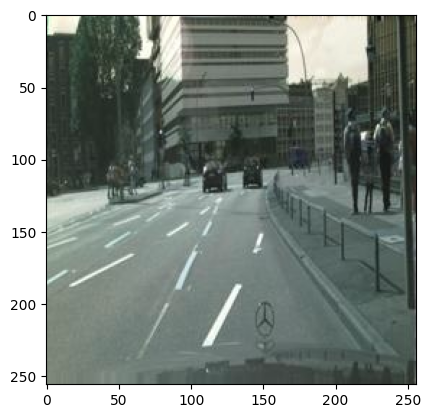

In [45]:
img='D:/Projects/Trinetra Datasets/Dataset/Images/image_302.jpg'
import cv2
im=cv2.imread(img)
im=np.array(im)
im=im/255
plt.imshow(im)
plt.show()